In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
k = 10 # number of arms
mean, stddev = 0.0, 1.0
mean_inc, stddev_inc = 0.0, 0.01
max_int = 2**32 - 1 # for random seed
alpha = 0.1 # constant stepsize
optimistic_initial_value = 5
ucb_c = 2
np.random.seed(2019)

In [3]:
class Method(Enum):
    SAMPLE_AVERAGE = 0
    CONSTANT_STEPSIZE = 1
    UNBIASED_CONSTANT_STEPSIZE = 2

In [4]:
def run(method, epsilon=0.1, n_steps=1000, stationary=True, optimistic=False, ucb=False, **kwargs):
    '''
    Returns history of average rewards, and history of percentages of optimal actions if stationary.
    '''
    
    if stationary:
        q_star = np.random.normal(mean, stddev, k)
        optimal = np.argmax(q_star)
        O = []
    else:
        q_star = np.zeros(k)
    
    if optimistic:
        Q = np.ones(k) * optimistic_initial_value
    else:
        Q = np.zeros(k)

    if method == Method.UNBIASED_CONSTANT_STEPSIZE:
        o = 0.0
    
    N = np.zeros(k)
    
    R = []
    for t in range(n_steps):
        if np.random.random() < epsilon:
            a = np.random.randint(k)
        else:
            if ucb:
                if any(N == 0):
                    # choose from those haven't been explored
                    Q_ = (N == 0)
                else:
                    Q_ = Q + ucb_c * np.sqrt(np.log(t) / N)
            else:
                Q_ = Q
            
            # Better than np.argmax(Q_) for breaking ties randomly
            a = np.random.choice(np.flatnonzero(Q_ == Q_.max()))
        
        if stationary:
            O.append(a == optimal)
        else:
            q_star += np.random.normal(mean_inc, stddev_inc, k)
        r = np.random.normal(q_star[a], stddev)
        R.append(r)
        
        N[a] += 1
        
        assert method in Method
        if method == Method.SAMPLE_AVERAGE:
            stepsize = 1 / N[a]
        elif method == Method.CONSTANT_STEPSIZE:
            stepsize = alpha
        elif method == Method.UNBIASED_CONSTANT_STEPSIZE:
            o += alpha * (1 - o)
            stepsize = alpha / o
        Q[a] += stepsize * (r - Q[a])

    R = np.cumsum(R)
    for t in range(n_steps):
        R[t] /= t+1
    
    if stationary:
        return R, O
    else:
        return R

# Section 2.3: The 10-armed Testbed

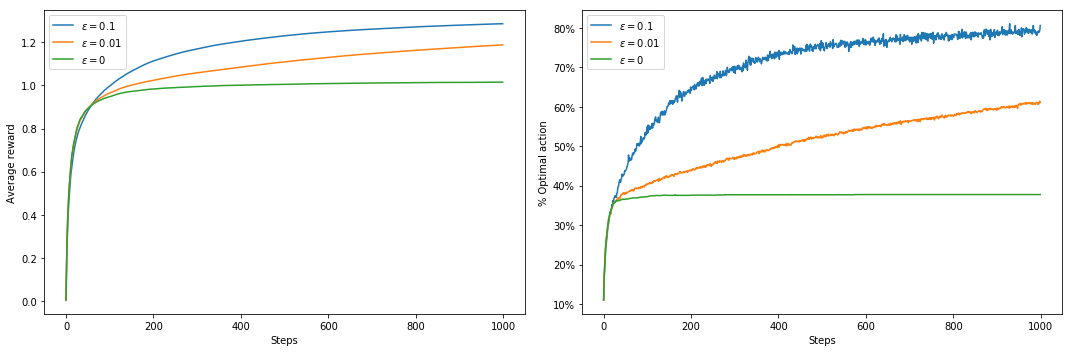

In [5]:
epsilons = [0.1, 0.01, 0]
Rs = [[] for _ in range(len(epsilons))]
Os = [[] for _ in range(len(epsilons))]

for i in range(2000):
    seed = np.random.randint(max_int)
    
    for j in range(len(epsilons)):
        np.random.seed(seed)
        R, O = run(Method.SAMPLE_AVERAGE, epsilon=epsilons[j])
        Rs[j].append(R)
        Os[j].append(O)

ylabels = ['Average reward', '% Optimal action']
plt.figure(figsize=(15, 5))
for i, Ys in enumerate([Rs, Os]):
    ax = plt.subplot(1, 2, i+1)
    for e in range(len(epsilons)):
        plt.plot(np.mean(Ys[e], axis=0))
    yticks = ax.get_yticks()
    ax.set_xlabel('Steps')
    ax.set_ylabel(ylabels[i])
    if '%' in ylabels[i]:
        ax.set_yticklabels([f'{int(ytick*100)}%' for ytick in yticks])
    plt.legend([fr'$\epsilon = {str(eps)}$' for eps in epsilons])

plt.tight_layout()
plt.show()

# Exercise 2.5

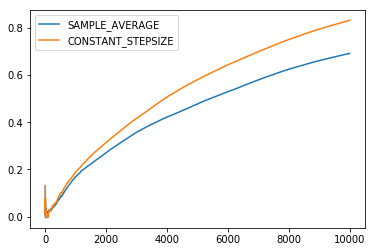

In [6]:
methods = [Method.SAMPLE_AVERAGE, Method.CONSTANT_STEPSIZE]
Rs = [[] for _ in range(len(methods))]

for i in range(100):
    seed = np.random.randint(max_int)
    
    for j in range(len(methods)):
        np.random.seed(seed)
        R = run(methods[j], epsilon=0.1, n_steps=10000, stationary=False)
        Rs[j].append(R)
    
for i in range(len(methods)):
    plt.plot(np.mean(Rs[i], axis=0))
plt.legend([method.name for method in methods])

plt.show()

# Section 2.6: Optimistic Initial Values

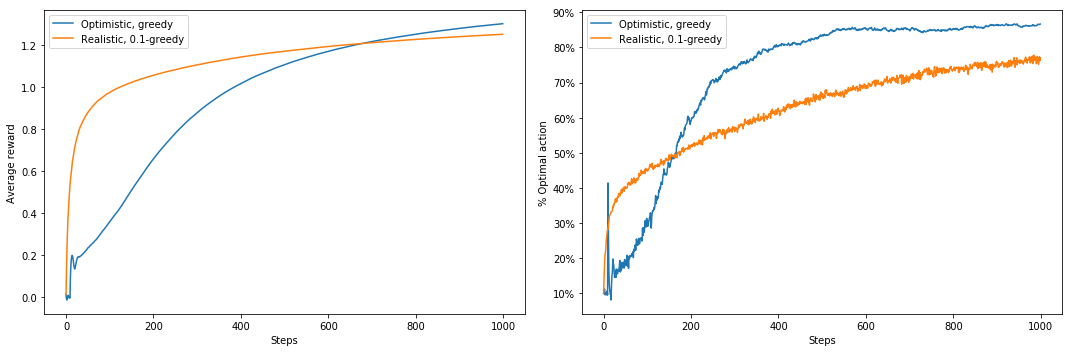

In [7]:
configs = [
    {'optimistic': True, 'epsilon': 0, 'name': 'Optimistic, greedy'},
    {'optimistic': False, 'epsilon': 0.1, 'name': 'Realistic, 0.1-greedy'},
]
Rs = [[] for _ in range(len(configs))]
Os = [[] for _ in range(len(configs))]

for i in range(2000):
    seed = np.random.randint(max_int)
    
    for j, config in enumerate(configs):
        np.random.seed(seed)
        R, O = run(Method.CONSTANT_STEPSIZE, **config)
        Rs[j].append(R)
        Os[j].append(O)

ylabels = ['Average reward', '% Optimal action']
plt.figure(figsize=(15, 5))
for i, Ys in enumerate([Rs, Os]):
    ax = plt.subplot(1, 2, i+1)
    for j in range(len(configs)):
        ax.plot(np.mean(Ys[j], axis=0))
    yticks = ax.get_yticks()
    ax.set_xlabel('Steps')
    ax.set_ylabel(ylabels[i])
    if '%' in ylabels[i]:
        ax.set_yticklabels([f'{int(ytick*100)}%' for ytick in yticks])
    ax.legend([config['name'] for config in configs])

plt.tight_layout()
plt.show()

In [8]:
# The mysterious spike occurs at the 11-th step.
# The reason is that after the first 10 actions,
# all of the 10 arms must have been explored,
# and it's likely that the next action is the optimal one.

early = np.mean(Os[0], axis=0)[:100]
np.argmax(early)

10

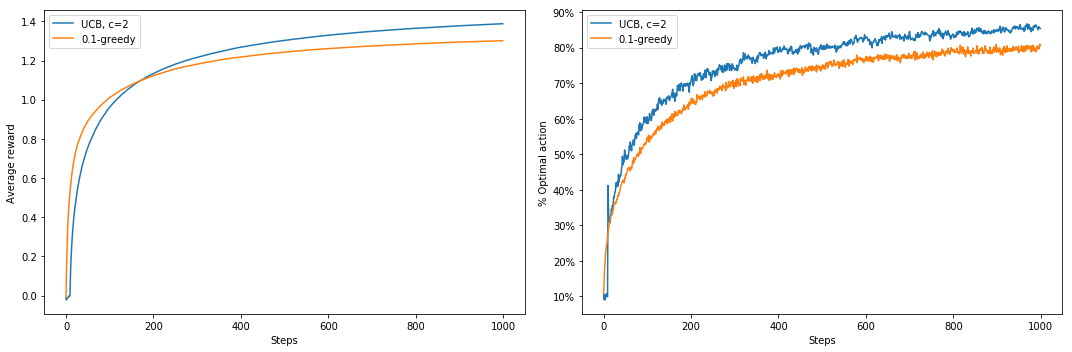

In [9]:
configs = [
    {'ucb': True, 'epsilon': 0, 'name': 'UCB, c=2'},
    {'ucb': False, 'epsilon': 0.1, 'name': '0.1-greedy'},
]
Rs = [[] for _ in range(len(configs))]
Os = [[] for _ in range(len(configs))]

for i in range(2000):
    seed = np.random.randint(max_int)
    
    for j, config in enumerate(configs):
        np.random.seed(seed)
        R, O = run(Method.SAMPLE_AVERAGE, **config)
        Rs[j].append(R)
        Os[j].append(O)

ylabels = ['Average reward', '% Optimal action']
plt.figure(figsize=(15, 5))
for i, Ys in enumerate([Rs, Os]):
    ax = plt.subplot(1, 2, i+1)
    for j in range(len(configs)):
        ax.plot(np.mean(Ys[j], axis=0))
    yticks = ax.get_yticks()
    ax.set_xlabel('Steps')
    ax.set_ylabel(ylabels[i])
    if '%' in ylabels[i]:
        ax.set_yticklabels([f'{int(ytick*100)}%' for ytick in yticks])
    ax.legend([config['name'] for config in configs])

plt.tight_layout()
plt.show()